# 03/17/21 - This notebook simulates the best fit model for 2730 as imaging for VST, VRO and HST (psf 0.65, 0.2, 0.1)

In [218]:
# libraries

from pyprojroot import here
print(f'You are here: {here()}')

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
#import matplotlib.patches as patches
from autoconf import conf
import autolens as al
import autolens.plot as aplt
import autofit as af
import scipy.stats as stats
from os import path

%matplotlib inline

from astropy import constants as const
from astropy.io import fits
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM, z_at_value

c = const.c.to('km/s').value #c in km/s
h0 = 73.8 #h0 in km/(Mpc*s) Riess2011
cosmo = FlatLambdaCDM(h0, Om0=0.262)

# paths
autoz_path = f'{here()}/'
file_path = f'{autoz_path}files/'
csv_path = f'{file_path}csv/'
fits_path = f'{file_path}fits/'
latest_path = f'{csv_path}latest/'
visual_path = f'{autoz_path}visuals/'
png_path = f'{visual_path}png/'
pdf_path = f'{visual_path}pdf/'
knabel2020_file_path = '/data/sknabel/lens_methods/files/'

gama_id = 3629152
links_id = 1933

object_folder = f'{fits_path}G{gama_id}_{links_id}/'
output_folder = f'{autoz_path}output/G{gama_id}_{links_id}/'

You are here: /data/sknabel/autoz_lens_model


Plotting r-band


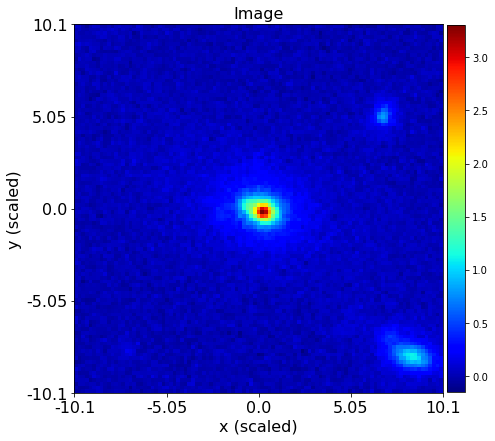

Plotting g-band


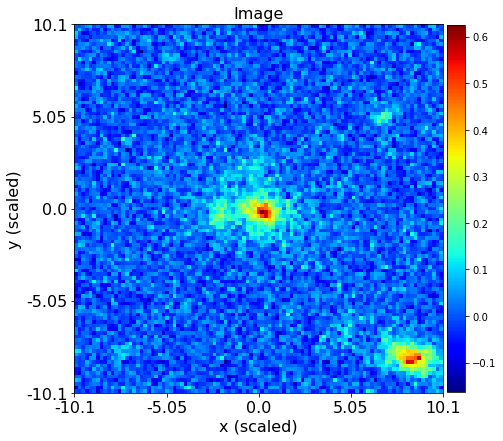

In [219]:
# load r-band imaging
imaging_r = al.Imaging.from_fits(image_path=path.join(object_folder, f'{links_id}_r_image.fits'),
                              noise_map_path=path.join(object_folder, f'{links_id}_r_noise_map_image.fits'),
                              psf_path=path.join(object_folder, f'{links_id}_r_psf_image.fits'),
                               pixel_scales=0.2)

# load g-band imaging
imaging_g = al.Imaging.from_fits(image_path=path.join(object_folder, f'{links_id}_g_image.fits'),
                              noise_map_path=path.join(object_folder, f'{links_id}_g_noise_map_image.fits'),
                              psf_path=path.join(object_folder, f'{links_id}_g_psf_image.fits'),
                               pixel_scales=0.2)

# plot images for first view
print('Plotting r-band')
imaging_plotter_r = aplt.ImagingPlotter( # this is where the noise is coming up weird
    imaging=imaging_r,# visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter_r.figures(image=True)
print('Plotting g-band')
imaging_plotter_g = aplt.ImagingPlotter( # this is where the noise is coming up weird
    imaging=imaging_g,# visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter_g.figures(image=True)

In [182]:
# aggregator pulls in results from output folder
agg = af.Aggregator(directory=f'{output_folder}experiment_4_phase3_fit_120321')
model = agg.model_results

print(model)

Aggregator loading phases... could take some time.

 A total of 1 phases and results were found.


Bayesian Evidence                                                                         1558.27577347
Maximum Likelihood                                                                        1593.15763522

Maximum Log Likelihood Model:

galaxies
    lens
        bulge
            elliptical_comps
                elliptical_comps_0                                                        -0.214
                elliptical_comps_1                                                        0.279
            intensity                                                                     0.034
            sersic_index                                                                  3.501
            mass_to_light_ratio                                                           8.550
            effective_radius                                                              2.228
        dark
          

In [183]:
# take the samples info for the max log likelihood, etc.
results = list(agg.values("samples"))[0]
# max log likelihood instance won't load because it's outside the bounds of my priors... which is stupid af.
print(results.max_log_likelihood_instance)
sample = results.max_log_likelihood_sample
instance = sample.instance_for_model(results.max_log_likelihood_sample)
print(instance)

PriorLimitException: The physical value 2.22845851953622 for a prior was not within its limits 0.0, 2.1135294437408447

In [180]:
help(results)

Help on method instance_at_sigma in module autofit.non_linear.samples:

instance_at_sigma(sigma) -> autofit.mapper.model.ModelInstance method of autofit.non_linear.samples.NestSamples instance
    The value of every parameter marginalized in 1D at an input sigma value of its probability density function
    (PDF), returned as a list of model instances corresponding to the lower and upper values estimated from the PDF.
    
    See *vector_at_sigma* for a full description of how the parameters at sigma are computed.
    
    Parameters
    ----------
    sigma : float
        The sigma within which the PDF is used to estimate errors (e.g. sigma = 1.0 uses 0.6826 of the PDF).



In [179]:
print(instance.galaxies.lens)

Redshift: [0.40662315]
Light Profiles:
EllipticalSersic
centre: (-0.09977304157510128, 0.09981813647810622)
elliptical_comps: (-0.18325600373395431, 0.13298506076531313)
axis_ratio: 0.6307575019633196
phi: -27.01619525931616
mass_to_light_ratio: 5.7030699093746
intensity: 0.03885333355525738
effective_radius: 2.037111021516207
sersic_index: 3.16224160368636
id: 92
_assertions: []
cls: <class 'autogalaxy.profiles.light_and_mass_profiles.EllipticalSersic'>
Mass Profiles:
EllipticalSersic
centre: (-0.09977304157510128, 0.09981813647810622)
elliptical_comps: (-0.18325600373395431, 0.13298506076531313)
axis_ratio: 0.6307575019633196
phi: -27.01619525931616
mass_to_light_ratio: 5.7030699093746
intensity: 0.03885333355525738
effective_radius: 2.037111021516207
sersic_index: 3.16224160368636
id: 92
_assertions: []
cls: <class 'autogalaxy.profiles.light_and_mass_profiles.EllipticalSersic'>
SphericalNFWMCRLudlow
mass_at_200: 30713640082.05637
redshift_object: [0.40662315]
redshift_source: [0.787

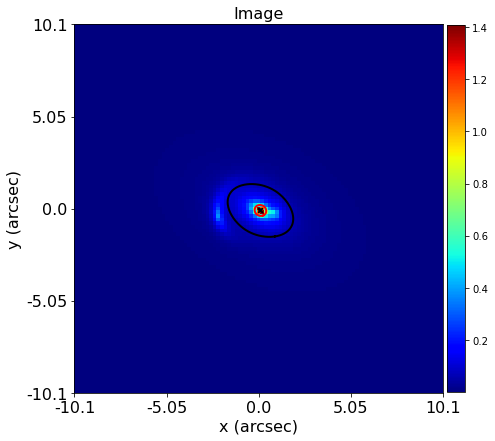

In [210]:
# let's take this median pdf instance to create our simulated lens
lens = instance.galaxies.lens
source = instance.galaxies.source

grid = al.Grid2DIterate.uniform(
    shape_native=(101, 101), pixel_scales=0.2, fractional_accuracy=0.9999
)

tracer = al.Tracer.from_galaxies(
    galaxies=[lens, source], cosmology=cosmo
)

tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=grid)
tracer_plotter.figures(image=True)

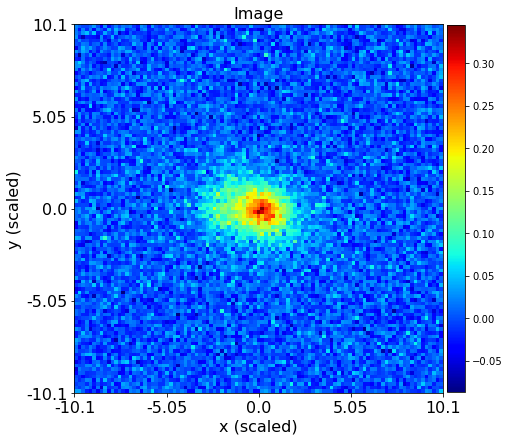

In [215]:
# simulate the VST image quality exactly as it would have been for our images
vst_psf = al.Kernel2D.from_gaussian(shape_native=(21, 21), sigma=0.65, pixel_scales=grid.pixel_scales, renormalize=True)

vst_simulator = al.SimulatorImaging(
    exposure_time=1800.0, background_sky_level=1.0, psf=vst_psf, add_poisson_noise=True # exp time depends on band (900, 1200, 1800)
)

imaging = vst_simulator.from_tracer_and_grid(tracer=tracer, grid=grid)

"""
By plotting a subplot of the `Imaging` dataset, we can see this object includes the observed image of the strong lens
(which has had noise and other instrumental effects added to it) as well as a noise-map and PSF:
"""
imaging_plotter = aplt.ImagingPlotter(imaging=imaging)
imaging_plotter.figures(image=True)

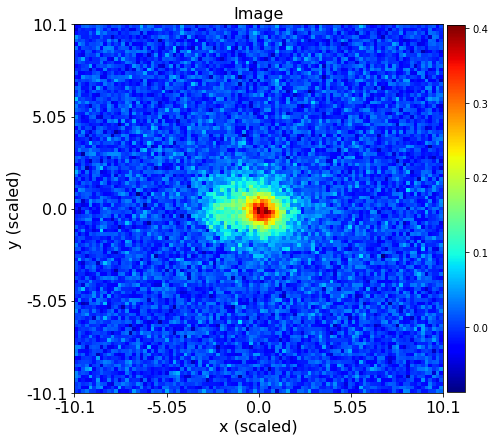

In [214]:
# simulate the VRO image quality
vro_psf = al.Kernel2D.from_gaussian(shape_native=(21, 21), sigma=0.5, pixel_scales=0.2)

vro_simulator = al.SimulatorImaging(
    exposure_time=1800.0, background_sky_level=1.0, psf=vro_psf, add_poisson_noise=True # exp time depends on band (900, 1200, 1800)
)

imaging = vro_simulator.from_tracer_and_grid(tracer=tracer, grid=grid)

"""
By plotting a subplot of the `Imaging` dataset, we can see this object includes the observed image of the strong lens
(which has had noise and other instrumental effects added to it) as well as a noise-map and PSF:
"""
imaging_plotter = aplt.ImagingPlotter(imaging=imaging)
imaging_plotter.figures(image=True)


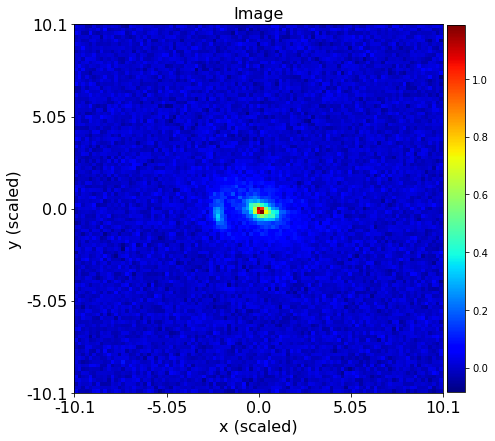

In [216]:
# simulate the HST image quality
hst_psf = al.Kernel2D.from_gaussian(shape_native=(21, 21), sigma=0.1, pixel_scales=0.2)

hst_simulator = al.SimulatorImaging(
    exposure_time=1800.0, background_sky_level=1.0, psf=hst_psf, add_poisson_noise=True # exp time depends on band (900, 1200, 1800)
)

imaging = hst_simulator.from_tracer_and_grid(tracer=tracer, grid=grid)

"""
By plotting a subplot of the `Imaging` dataset, we can see this object includes the observed image of the strong lens
(which has had noise and other instrumental effects added to it) as well as a noise-map and PSF:
"""
imaging_plotter = aplt.ImagingPlotter(imaging=imaging)
imaging_plotter.figures(image=True)


## Simulate a pretty lens just to see what it looks like.

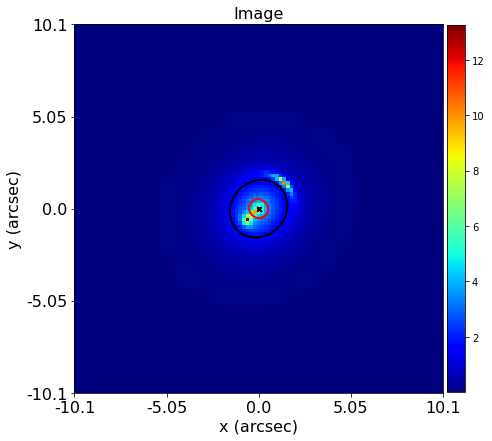

In [246]:
lens_galaxy_0 = al.Galaxy(
    redshift=0.5,
    bulge=al.lmp.EllipticalSersic(
        centre=(0.0, 0.0),
        elliptical_comps = al.convert.elliptical_comps_from(axis_ratio=0.9,phi=45.0),
        intensity=0.5,
        effective_radius=0.3,
        sersic_index=2.5,
        mass_to_light_ratio=0.3,
    ),
    disk=al.lmp.EllipticalExponential(
        centre=(0.0, 0.0),
        elliptical_comps = al.convert.elliptical_comps_from(axis_ratio=0.9,phi=45.0),
        intensity=1.0,
        effective_radius=2.0,
        mass_to_light_ratio=0.2,
    ),
    dark=al.mp.SphericalNFW(centre=(0.0, 0.0), kappa_s=0.08, scale_radius=30.0),
)

#lens_galaxy_1 = al.Galaxy(
#    redshift=1.0,
#    light=al.lp.EllipticalExponential(
#        centre=(0.1, 0.1), , elliptical_comps=(0.1, 0.1), intensity=3.0, effective_radius=0.1
#    ),
#    mass=al.mp.EllipticalIsothermal(
#        centre=(0.1, 0.1), , elliptical_comps=(0.1, 0.1), einstein_radius=0.4
#    ),
#)

source_galaxy = al.Galaxy(
    redshift=2.0,
    light=al.lp.EllipticalSersic(
        centre=(0.2, 0.2),
        elliptical_comps=(-0.055555,0.096225),
        intensity=2.0,
        effective_radius=0.1,
        sersic_index=1.5,
    ),
)


tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy_0, source_galaxy])

tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=grid)
tracer_plotter.figures(image=True)